In [4]:
import requests
import json
import pandas as pd
from pandas import json_normalize

# Your API key
API_KEY = 'key'
search_query = 'TITLE-ABS-KEY("metabolite") AND TITLE-ABS-KEY("plant") AND PUBYEAR = {}'

# Scopus API endpoint for the search
scopus_search_url = 'https://api.elsevier.com/content/search/scopus'

# Set up the headers with the API key
headers = {
    'X-ELS-APIKey': API_KEY
}

# Initialize an empty list to store results
all_documents = []

# Loop through the year span from 2010 to 2022
for year in range(2014, 2023):
    # Set up the parameters for the search with the specific year in the query
    params = {
        'query': search_query.format(year),
        'field': 'title,creator,affiliation,citedby-count,coverDate',
        'count': 25  # Adjust the count as needed
    }

    # Start index for pagination
    start_index = 0

    while True:
        # Set the start index in the params
        params['start'] = start_index

        # Perform the search
        response = requests.get(scopus_search_url, headers=headers, params=params)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Parse the JSON response
            search_results = response.json()

            # Access the list of documents
            documents = search_results.get('search-results', {}).get('entry', [])

            # Break the loop if no more results
            if not documents:
                break

            # Append the batch of documents to the list
            all_documents.extend(documents)

            # Increment the start index for the next page
            start_index += params['count']

        else:
            print(f'Error: {response.status_code} - {response.text}')
            break

    # Normalize JSON data
    norm_documents = json_normalize(all_documents)

    norm_documents2 = norm_documents.dropna(subset=['affiliation'])

    # Extract the first author information from each row
    first_author_info = []
    for row in norm_documents2['affiliation']:
        if row:
            first_author_info.append({
                'affilname': row[0]['affilname'],
                'affiliation-city': row[0]['affiliation-city'],
                'affiliation-country': row[0]['affiliation-country']
            })
        else:
            # Handle the case where the row is empty or doesn't contain the expected structure
            first_author_info.append({
                'affilname': None,
                'affiliation-city': None,
                'affiliation-country': None
            })

    # Create a DataFrame from the extracted information
    aff_data = pd.DataFrame(first_author_info)

    a = norm_documents2[['prism:url', 'dc:title', 'citedby-count', 'dc:creator', 'prism:coverDate']]

    # Result
    final_data = pd.concat([a, aff_data.set_axis(a.index)], axis=1)

    # Save the file for each year
    final_data.to_csv(f"scopus_metadata_{year}.csv")

    # Clear the list for the next iteration
    all_documents.clear()

print("Processing complete.")


Error: 500 - {"service-error":{"status":{"statusCode":"GENERAL_SYSTEM_ERROR","statusText":"Error calling Solr Search Service"}}}
Error: 400 - {"service-error":{"status":{"statusCode":"INVALID_INPUT","statusText":"Exceeds the number of search results"}}}
Error: 400 - {"service-error":{"status":{"statusCode":"INVALID_INPUT","statusText":"Exceeds the number of search results"}}}
Error: 400 - {"service-error":{"status":{"statusCode":"INVALID_INPUT","statusText":"Exceeds the number of search results"}}}
Error: 400 - {"service-error":{"status":{"statusCode":"INVALID_INPUT","statusText":"Exceeds the number of search results"}}}
Error: 400 - {"service-error":{"status":{"statusCode":"INVALID_INPUT","statusText":"Exceeds the number of search results"}}}
Error: 400 - {"service-error":{"status":{"statusCode":"INVALID_INPUT","statusText":"Exceeds the number of search results"}}}
Processing complete.


# Analyze data
## concatenate all csv's

In [11]:
import os
import glob
import pandas as pd

# Step 1: Load all CSV files in the folder
folder_path = 'scopus_metadata'  # Replace with the actual path to your folder
file_pattern = 'scopus_metadata*.csv'
all_files = glob.glob(os.path.join(folder_path, file_pattern))

# Check if there are any files
if not all_files:
    print("No files found.")
else:
    # Concatenate all files into a single DataFrame
    df_list = [pd.read_csv(file) for file in all_files]
    concatenated_df = pd.concat(df_list, ignore_index=True)

concatenated_df.columns

Index(['Unnamed: 0', 'prism:url', 'dc:title', 'citedby-count', 'dc:creator',
       'prism:coverDate', 'affilname', 'affiliation-city',
       'affiliation-country'],
      dtype='object')

## Plots

### Publications over time

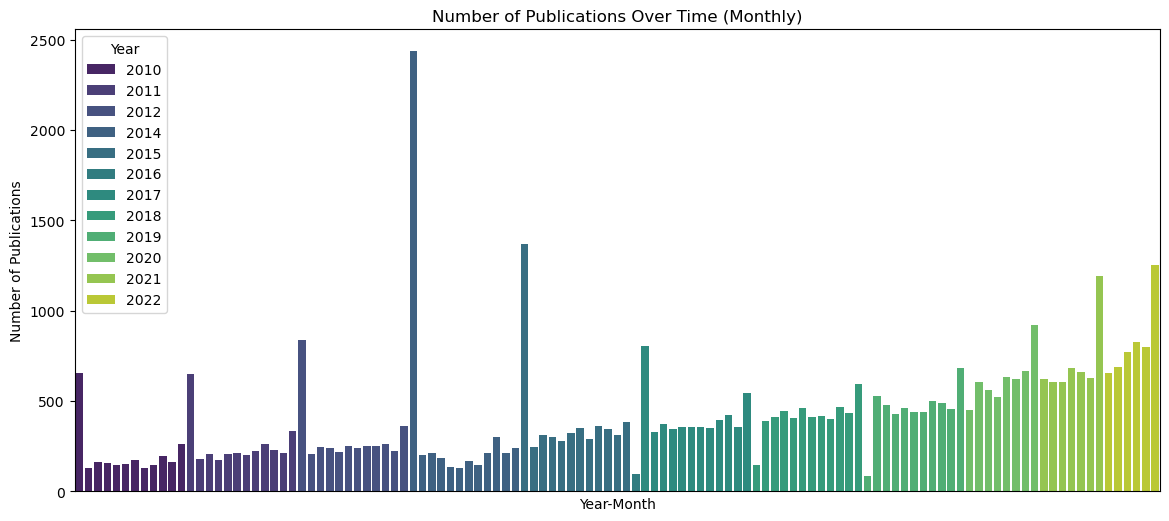

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'prism:coverDate' to datetime
concatenated_df['prism:coverDate'] = pd.to_datetime(concatenated_df['prism:coverDate'])

# Extract year and month from 'prism:coverDate'
concatenated_df['YearMonth'] = concatenated_df['prism:coverDate'].dt.to_period('M')

# Plotting a bar chart for the number of publications over time with monthly x-axis and colored by year
plt.figure(figsize=(14, 6))
sns.countplot(x='YearMonth', data=concatenated_df, hue = 'Year', palette='viridis',dodge=False)
plt.title('Number of Publications Over Time (Monthly)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Publications')
plt.xticks([])
plt.show()


### Publications per first author's affiliation country

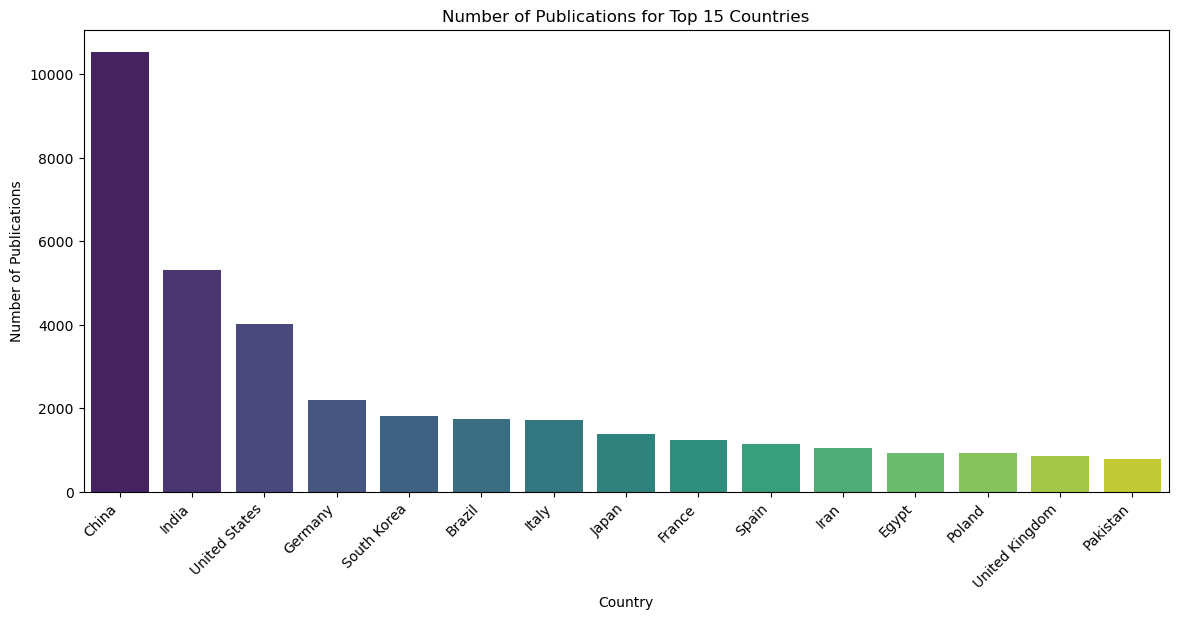

In [76]:
# Assuming 'affiliation-country' is the column containing country information
top_countries = concatenated_df['affiliation-country'].value_counts().nlargest(15).index

# Filter the DataFrame to include only the top 15 countries
top_countries_df = concatenated_df[concatenated_df['affiliation-country'].isin(top_countries)]

# Count the number of publications for each country
publications_by_country = top_countries_df['affiliation-country'].value_counts().reset_index()
publications_by_country.columns = ['Country', 'Number of Publications']

# Plotting the number of publications for the top 15 countries
plt.figure(figsize=(14, 6))
sns.barplot(x='Country', y='Number of Publications', data=publications_by_country, palette='viridis')
plt.title('Number of Publications for Top 15 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45, ha='right')
plt.show()


### Publications per first author's affiliation

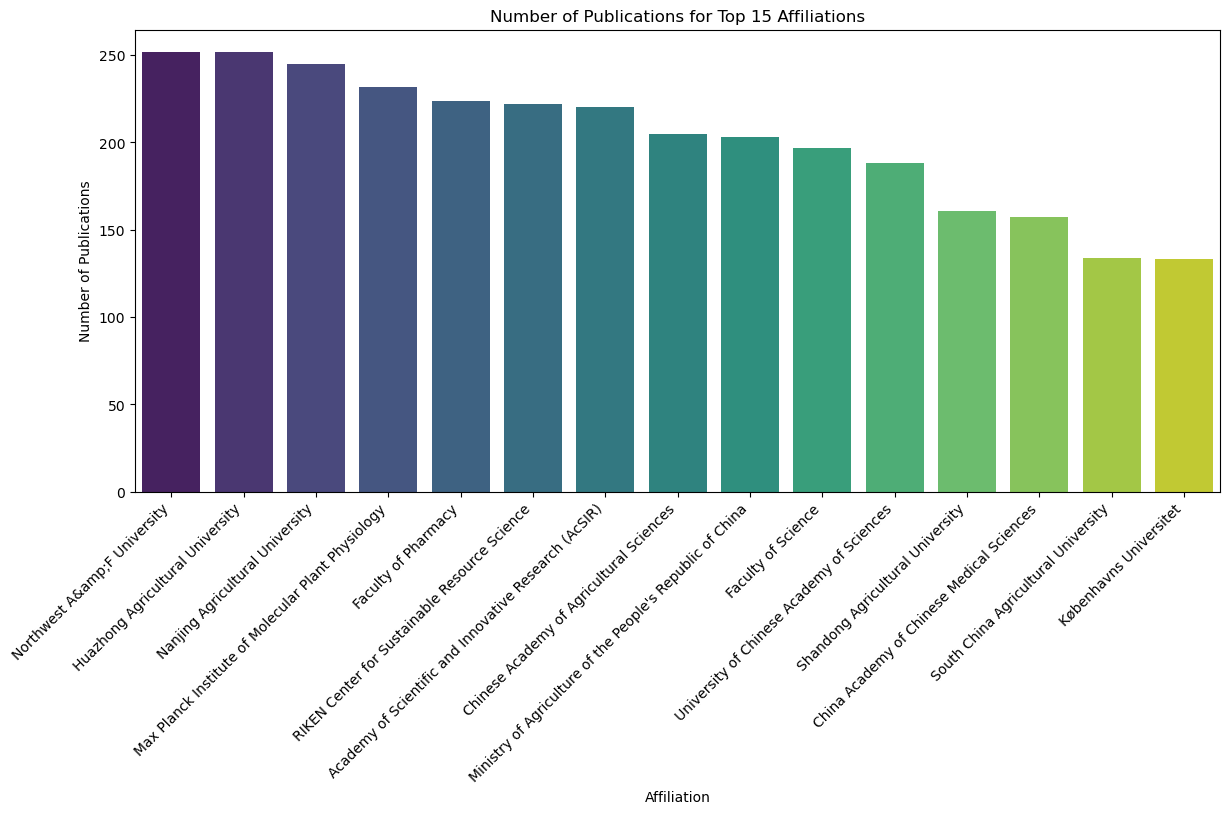

In [79]:
# Assuming 'affilname' is the column containing affiliation information
top_affiliations = concatenated_df['affilname'].value_counts().nlargest(15).index

# Filter the DataFrame to include only the top 15 affiliations
top_affiliations_df = concatenated_df[concatenated_df['affilname'].isin(top_affiliations)]

# Count the number of publications for each affiliation
publications_by_affiliation = top_affiliations_df['affilname'].value_counts().reset_index()
publications_by_affiliation.columns = ['Affiliation', 'Number of Publications']

# Plotting the number of publications for the top 15 affiliations
plt.figure(figsize=(14, 6))
sns.barplot(x='Affiliation', y='Number of Publications', data=publications_by_affiliation, palette='viridis')
plt.title('Number of Publications for Top 15 Affiliations')
plt.xlabel('Affiliation')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45, ha='right')
plt.show()


### Publications per first author's name

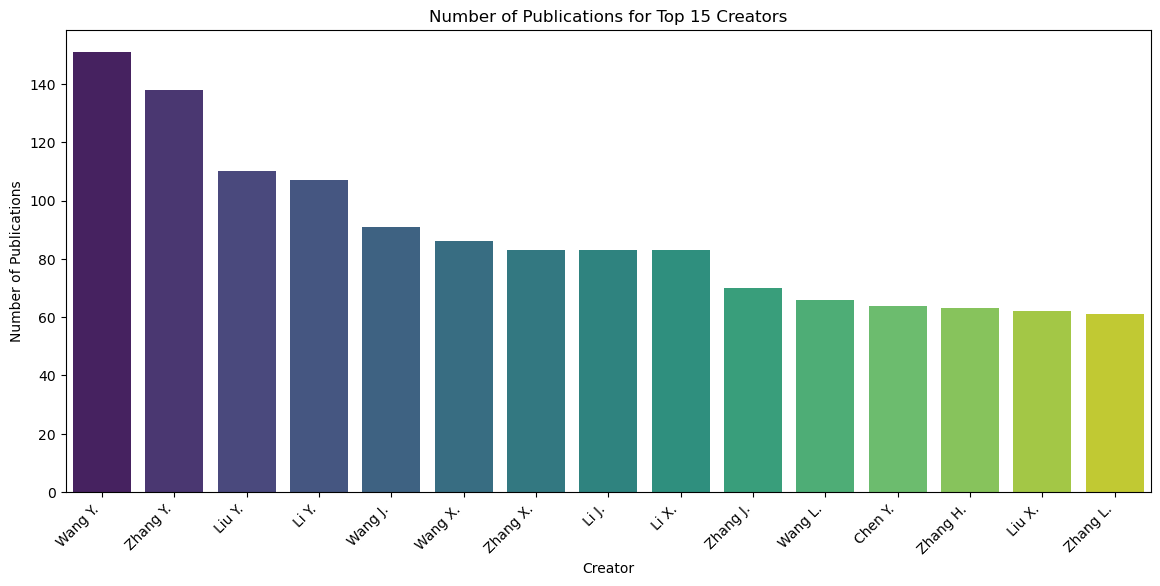

In [81]:
# Assuming 'dc:creator' is the column containing creator information
top_creators = concatenated_df['dc:creator'].value_counts().nlargest(15).index

# Filter the DataFrame to include only the top 15 creators
top_creators_df = concatenated_df[concatenated_df['dc:creator'].isin(top_creators)]

# Count the number of publications for each creator
publications_by_creator = top_creators_df['dc:creator'].value_counts().reset_index()
publications_by_creator.columns = ['Creator', 'Number of Publications']

# Plotting the number of publications for the top 15 creators
plt.figure(figsize=(14, 6))
sns.barplot(x='Creator', y='Number of Publications', data=publications_by_creator, palette='viridis')
plt.title('Number of Publications for Top 15 Creators')
plt.xlabel('Creator')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45, ha='right')
plt.show()
